## **Differentially expressed genes in a microarray RNA dataset**

In this notebook, we will work with microarray RNA data generated by investigating tumour and normal cancer cells. We will investigate the genes that are differentially expressed in both conditions. Similarly, we will perform some data preprocessing and visualisation steps to preprocess data for analysis and to understand the data, respectively. 

We will load in extracted dataset with their metadata. Preprocessing steps to apply would be to investigate the distribution of the data to determine the presence of outliers and handling them, if present. Preliminary exploration to be performed would be to visualise the distribution of the genes expressed in all samples. Due to the large number of genes, we will select a few of them. Similarly, we will decompose these genes into smaller dimensions to determine variations in the data in terms of their principal components (Principal Component Analysis, PCA). Next, we will cluster them to determine the number of clusters that could be obtained. We will use two forms: KMeans and Hierarchical clustering. Furthermore, we will visualise the local and global relationships between genes by using the Uniform Manifold Approximation and Projection (UMAP). We will overlay these with the target classes. 

Differential Gene Expression (DGE) analysis will be performed to determine genes that are upregulated and downregulated in the diseased state. We will be using both a T-test statistical test and a linear model (there exist more sophisticated methods). The dataset we will be using is one with the GEO accession number `GSE116520`. This data was generated while performing the transcriptome profiling of PDZ Binding Kinase, a novel biomarker, found in the peritumoral brain zone of glioblastoma (cancer). The total RNA from tumour core (TC), Peritumoural brain zone (PT) and non-neoplastic brain tissue (a control) samples were subjected to Illumna bead array. This dataset has been normalised by quantile normalisation and then log2-scaled, hence no transformation will be done.

In [1]:
from pathlib import os
from glob import glob
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Literal, Union, Optional
import plotnine as pn
from sklearn import preprocessing, cluster, metrics
# from scipy.spatial.distance import pdist, squareform
from scipy import stats
from collections import Counter
from tqdm import tqdm
from scipy.cluster.hierarchy import linkage, dendrogram
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests # for adjusted pvals
from sklearn.decomposition import PCA
import gseapy as gspy
import csv

In [2]:
path = os.getcwd()

In [3]:
def read_data(file_id:str, file_type:str, folder:str=None) -> pd.DataFrame:
    """
    Reads data from a file and returns a Pandas DataFrame
    
    :param file_id : File identifier
    :param file_type : Type of data to read. Either a metadata or counts data containing expressed genes
    :param folder: Folder name
    
    Returns
    -------
    Pandas DataFrame
    """
    try:
        file = None
        if folder:
            filepath = os.path.join(path, folder)
            file = glob(filepath + f'/{file_id}*{file_type}*.csv')[0]
        else:
            file = glob(path + f'/{file_id}*{file_type}*.csv')[0]
        
        df = pd.read_csv(file, index_col=0)
        return df
    except Exception as err: print(err)

In [4]:
metadata = read_data('GSE116520', 'metadata', 'microarray').reset_index()
gene_counts = read_data('GSE116520', 'counts', 'microarray').T

In [5]:
gene_counts.head()

ID_REF,ILMN_1343291,ILMN_1343295,ILMN_1651199,ILMN_1651209,ILMN_1651210,ILMN_1651221,ILMN_1651228,ILMN_1651229,ILMN_1651230,ILMN_1651232,...,ILMN_3311145,ILMN_3311150,ILMN_3311155,ILMN_3311160,ILMN_3311165,ILMN_3311170,ILMN_3311175,ILMN_3311180,ILMN_3311185,ILMN_3311190
GSM3242216,14.032437,12.435607,6.402662,6.666138,6.579272,6.815710,10.966710,8.666884,6.284195,6.592901,...,6.468024,6.406803,6.537197,6.291450,6.716895,6.268282,6.350572,6.377081,6.439392,6.628033
GSM3242217,14.012624,13.379158,6.326161,6.661021,6.360057,6.401387,10.051240,8.908373,6.271326,6.535644,...,6.477359,6.531178,6.712899,6.362179,6.748707,6.383871,6.377871,6.448808,6.568940,6.811224
GSM3242218,13.864100,13.484528,6.372270,6.652996,6.518094,6.480741,12.787245,8.442132,6.391237,6.818070,...,6.589392,6.488869,6.619293,6.476174,6.776191,6.367891,6.393227,6.317557,6.411717,6.602096
GSM3242219,14.059140,13.328843,6.292105,6.633443,6.307037,6.411210,12.437371,10.011964,6.366073,6.549965,...,6.619073,6.570316,6.586012,6.316149,6.803801,6.416242,6.289540,6.582053,6.418153,6.785057
GSM3242220,13.797549,13.282239,6.357153,6.826525,6.564816,6.377278,12.727407,9.363087,6.471363,6.646395,...,6.760732,6.418721,6.499872,6.303477,7.011902,6.327228,6.481871,6.418349,6.430580,6.600433


In [6]:
metadata.head()

,disease state,grade,tissue,gender,age,class,sample_id
0,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242216
1,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242217
2,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242218
3,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242219
4,Glioblastoma,Gbm who grade iv tumour tissue,Tumour core,Male,Adult,Glioblastoma,GSM3242220


In [7]:
def get_outliers(x:Union[pd.DataFrame, np.ndarray], method:Literal['zscore', 'iqr']='zscore') -> int:
    if not isinstance(x, (pd.DataFrame, np.ndarray)):
        raise ValueError ('x must be a Pandas DataFrame or Numpy array')
    try:
        if method == 'zscore':
            x_mean = np.mean(x, axis=0)
            x_std = np.std(x, axis=0)
            x_scaled = (x - x_mean)/x_std
            n_outliers = np.sum(abs(x_scaled) > 3, axis=0)
            return n_outliers
        elif method == 'iqr':
            p25 = np.percentile(x, q=25, axis=0)
            p75 = np.percentile(x, q=75, axis=0)
            iqr = p75 - p25
            lower = p25 - 1.5*iqr
            upper = p75 + 1.5*iqr
            n_outliers = np.sum((x < lower) | (x > upper), axis=0)
            return n_outliers
    except Exception as err: print(err)

In [8]:
def winsorizer(df:Union[pd.DataFrame, np.ndarray], percent:Union[int,float]=0.9):
    """
    Winsorizes data based on a certain percent
    :param df: A pandas dataframe or numpy array
    :param percent: Percentage cutoff point where values below or above limits are winsorized. A float or int
    """
    if not isinstance(df, (pd.DataFrame, np.ndarray)):
        raise ValueError ('df must be a Pandas DataFrame or Numpy array')
    if not isinstance(percent, (int, float)):
        raise ValueError (f'{percent} must be an integer or float')
    cutoff = round((100-percent)/2 if percent > 1 else 100*((1-percent)/2),3)
    upper_percentile = np.percentile(df, q=100-cutoff, axis=0)
    lower_percentile = np.percentile(df, q=cutoff, axis=0)

    upper_limit = np.max(df[df <= upper_percentile], axis=0)
    lower_limit = np.min(df[df >= lower_percentile], axis=0)
    df_winsorised = np.where(
        df < lower_limit, lower_limit, 
        np.where(df > upper_limit, upper_limit, df)
        )
    
    if df.__class__.__name__ == 'DataFrame':
        cols = df.columns
        index = df.index
        df_winsorised = pd.DataFrame(df_winsorised, columns=cols, index=index)
    return df_winsorised

In [9]:
def IQR_trimming(df:Union[pd.DataFrame, np.ndarray], cutoff=3):
    """
    Handles Outliers by capping outliers to the minimum and maximum values 
    without the outliers based on Intequartile range
    
    :param df: A pandas dataframe or numpy array
    :param cutoff: value to indicate outliers
    """
    if not isinstance(df, (pd.DataFrame, np.ndarray)):
        raise ValueError ('df must be a Pandas DataFrame or Numpy array')
    
    df_copy = df.copy()
    if isinstance(df, pd.DataFrame):
        df_copy = df_copy.to_numpy()
    
    p25 = np.percentile(df_copy, q=25, axis=0)
    p75 = np.percentile(df_copy, q=75, axis=0)
    iqr = p75 - p25

    lower_limit = p25 - cutoff*iqr
    upper_limit = p75 + cutoff*iqr
    
    # replace outliers by capping
    df_copy = np.where(
        df_copy < lower_limit, lower_limit, 
        np.where(df_copy > upper_limit, upper_limit, df_copy)
        )

    if df.__class__.__name__ == 'DataFrame':
        cols = df.columns
        index = df.index
        df_copy = pd.DataFrame(df_copy, columns=cols, index=index)
    return df_copy

In [10]:
def zscore_trimming(df:Union[pd.DataFrame, np.ndarray], cutoff=3):
    """
    Handles Outliers by capping outliers to the minimum and maximum values 
    without the outliers based on ZScore method
    
    :param df: A pandas dataframe or numpy array
    :param cutoff: Absolute value to indicate outliers
    """
    if not isinstance(df, (pd.DataFrame, np.ndarray)):
        raise ValueError ('df must be a Pandas DataFrame or Numpy array')
    
    df_copy = df.copy()
    if isinstance(df, pd.DataFrame):
        df_copy = df_copy.to_numpy()
    
    # scale data
    df_scaled = preprocessing.scale(df_copy, axis=0)
    
    # get lower and upper limits (min and max values without the outliers) of each gene in each sample 
    for i in tqdm(range(df_copy.shape[1])):
        outliers = abs(df_scaled[:, i]) > cutoff
        gene_data = df_copy[:, i]
        gene_data_inliers = gene_data[~outliers] # get gene data inlier
        upper_limit = np.max(gene_data_inliers) # get max and min values
        lower_limit = np.min(gene_data_inliers)

        # replace outliers
        gene_data = np.where(
            gene_data < lower_limit, lower_limit, 
            np.where(gene_data > upper_limit, upper_limit, gene_data)
            )
        df_copy[:, i] = gene_data
    
    if df.__class__.__name__ == 'DataFrame':
        cols = df.columns
        index = df.index
        df_copy = pd.DataFrame(df_copy, columns=cols, index=index)
    return df_copy

In [11]:
def outlier_treatment(df:Union[pd.DataFrame, np.ndarray], 
                      cutoff=Union[None, float, int], 
                      percent=Union[None, float, int],
                      treatment_type:Literal['winsorize', 'iqr', 'zscore', None]=None):
    
    if treatment_type == 'winsorize':
        if percent:
            df_copy = winsorizer(df, percent=percent)
    elif treatment_type == 'iqr':
        if cutoff:
            df_copy = IQR_trimming(df, cutoff=cutoff)
    elif treatment_type == 'zscore':
        if cutoff:
            df_copy = zscore_trimming(df, cutoff=cutoff)
    elif treatment_type is None:
        df_copy = df
    else:
        print(f'{treatment_type} not recognised!')
        exit(1)
    return df_copy

In [12]:
def describe_data(x:Union[pd.DataFrame, np.array]) -> pd.DataFrame:
    if isinstance(x, np.ndarray):
        cols = list(map(lambda x: f'col{x}', range(1, x.shape[1]+1)))
        x = pd.DataFrame(x, columns=cols)
    elif isinstance(x, pd.DataFrame):
        cols = x.columns
    else:
        raise TypeError (f'Input value must be a Pandas dataFrame or a Numpy array')
    
    res = pd.DataFrame(columns=cols)
    res.loc['std', :] = x.std()
    res.loc['mean', :] = x.mean()
    res.loc['min', :] = x.min()
    res.loc['p25', :] = x.quantile(q=0.25)
    res.loc['median', :] = x.median()
    res.loc['p75', :] = x.quantile(q=0.75)
    res.loc['max', :] = x.median()
    res.loc['skew', :] = x.skew()
    res.loc['kurt', :] = x.kurtosis()
    res.loc['iqr', :] = x.quantile(q=0.75) - x.quantile(q=0.25)
    res.loc['num_outliers'] = get_outliers(x)
    return res

In [13]:
describe_data(gene_counts)

ID_REF,ILMN_1343291,ILMN_1343295,ILMN_1651199,ILMN_1651209,ILMN_1651210,ILMN_1651221,ILMN_1651228,ILMN_1651229,ILMN_1651230,ILMN_1651232,...,ILMN_3311145,ILMN_3311150,ILMN_3311155,ILMN_3311160,ILMN_3311165,ILMN_3311170,ILMN_3311175,ILMN_3311180,ILMN_3311185,ILMN_3311190
std,0.125957,0.589562,0.080604,0.145373,0.09926,0.097761,1.144026,0.688103,0.075226,0.177273,...,0.120861,0.128312,0.073656,0.095072,0.166276,0.064201,0.072966,0.087624,0.072122,0.117453
mean,13.926293,12.418963,6.333701,6.690445,6.404587,6.478372,11.860025,9.306087,6.358787,6.638635,...,6.576072,6.396261,6.591913,6.374951,6.728698,6.369746,6.405246,6.449572,6.408854,6.691111
min,13.501263,11.335841,6.148102,6.497278,6.232493,6.318572,9.499166,7.905329,6.174246,6.320079,...,6.31735,6.158887,6.454757,6.223618,6.442508,6.250605,6.261609,6.305062,6.240016,6.448094
p25,13.860314,12.000518,6.292225,6.58648,6.331993,6.411592,10.800566,8.807137,6.30319,6.547422,...,6.486259,6.321929,6.536916,6.302833,6.60658,6.328545,6.352323,6.396597,6.3594,6.613151
median,13.961921,12.505506,6.326258,6.665291,6.39394,6.478132,12.475758,9.277022,6.367537,6.614565,...,6.572406,6.383431,6.587473,6.366555,6.717755,6.370514,6.408238,6.440343,6.42092,6.684307
p75,14.02324,12.781224,6.370507,6.755094,6.450305,6.534021,12.595113,9.932507,6.403193,6.696191,...,6.653655,6.444543,6.632121,6.428926,6.807015,6.420117,6.440946,6.499538,6.444807,6.748071
max,13.961921,12.505506,6.326258,6.665291,6.39394,6.478132,12.475758,9.277022,6.367537,6.614565,...,6.572406,6.383431,6.587473,6.366555,6.717755,6.370514,6.408238,6.440343,6.42092,6.684307
skew,-1.19919,-0.115896,0.707718,1.301324,0.574906,0.939734,-1.043338,0.052102,-0.076805,1.414092,...,0.221742,1.494927,0.153865,0.779587,0.573456,-0.105354,0.68335,0.645494,0.074421,0.25376
kurt,2.105957,-0.793267,1.864839,2.285713,-0.439367,2.143543,-0.712402,-0.592191,0.037035,3.860046,...,-0.354566,4.93884,-0.714317,0.738076,-0.312222,-0.681512,1.095257,0.268118,0.330502,0.129315
iqr,0.162927,0.780707,0.078282,0.168614,0.118312,0.122429,1.794548,1.12537,0.100003,0.148769,...,0.167396,0.122614,0.095205,0.126093,0.200435,0.091572,0.088623,0.102941,0.085407,0.134919


In [14]:
def plot_distribution(df, num_genes=15, ncol=5, nrow=3, seed=None, 
                      figsize=(12,6), plot_type='kde'):
    """
    Plots the distribution of randomly selected genes against the class

    :param df: Pandas dataframe
    :param num_genes: Number of genes to plot distribution
    :param seed: Random seed value

    Returns a Matplotlib figure
    """
    try:
        if seed:
            rnd = np.random.RandomState(seed)
            random_idx = rnd.choice(range(df.shape[1]), num_genes, replace=False)
        else:
            random_idx = np.random.choice(range(df.shape[1]), num_genes, replace=False)

        selected_cols = df.columns[random_idx]

        # visualise
        plt.rcParams['font.size'] = 8
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
        axes = axes.flatten()
        for col, ax in zip(selected_cols, axes):
            if plot_type == 'box':
                sns.boxplot(data=df, x=metadata['class'].values, y=col, hue=metadata['class'].values, ax=ax, width=0.6)
            elif plot_type == 'kde':
                sns.kdeplot(data=df, x=col, hue=metadata['class'].values, ax=ax)
            ax.set(xlabel='', ylabel='')
            ax.set_title(f"Gene: {col.replace('_', ' ')}", loc='left', fontsize=9, fontweight='bold')
        fig.tight_layout()
        plt.rcdefaults()
        plt.show()
    except Exception as err: print(err)

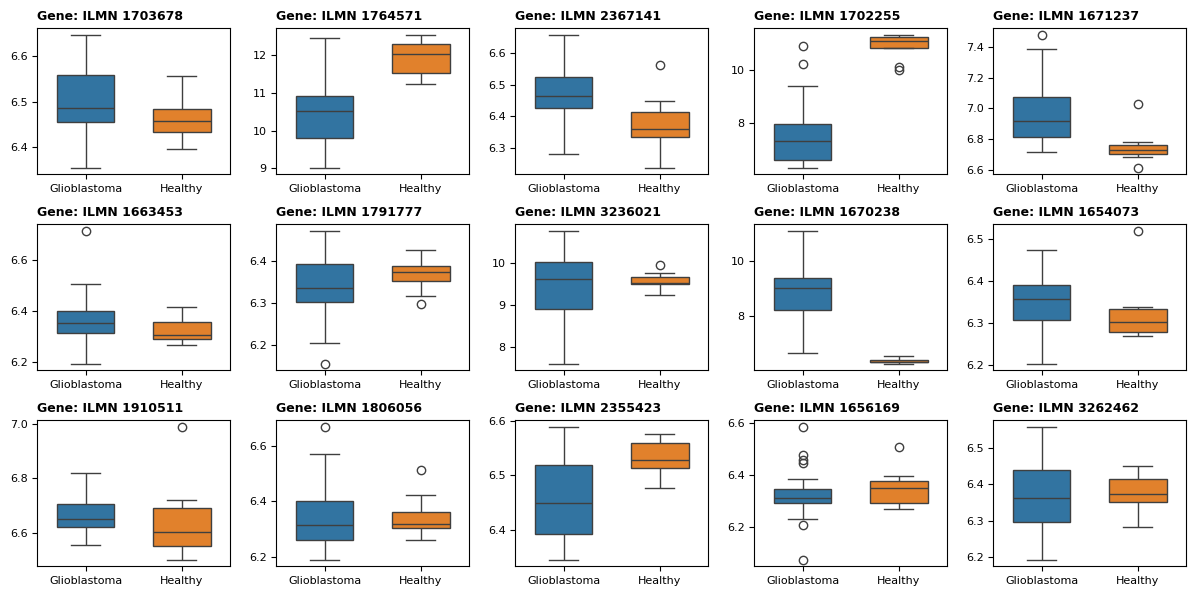

In [15]:
plot_distribution(gene_counts, plot_type='box', seed=10)

- By visualising some of the genes by cancerous and healthy tissues, we can clearly see that there are some genes that are differentiated during healthy and diseased state
- Also, we see the presence of outliers in some of the groups.
- Quantile transformation involves normalising gene samples such that the distribution of gene expression values is the same across all samples. Another method is the Robust Multi-Array Average (RMA) which performs background correction of array signals, normalisation and summarisation based on median values

__Outlier Treatment__

We will use the winsoriser method to treat outliers

In [16]:
# gene_counts = outlier_treatment(gene_counts, percent=90, treatment_type='winsorize')

In [17]:
# plot_distribution(gene_counts, plot_type='box', seed=10)

__Dimensionality Reduction and Visualisation__

Here, we will decompose the genes into smaller components (2) and visualise them in 2D-projection. We will use the PCA technique which decomposes gene data into principal components which are directions in the feature space that capture the largest variance. Next, we will apply UMAP method.

In [18]:
def reduce_dimensions(df, n_components=2, reduction_type:Literal['pca', 'umaps']='pca'):
    try:
        X_scaled = preprocessing.scale(df, axis=0)
        
        if reduction_type == 'pca':
            reducer = PCA(n_components=n_components, random_state=42)
            X_trans = reducer.fit_transform(X_scaled)
        elif reduction_type == 'umaps':
            reducer = umap.UMAP(n_components=n_components, random_state=42, n_jobs=1)
            X_trans = reducer.fit_transform(X_scaled)
        
        return pd.DataFrame(X_trans, columns=[f'PC{i+1}' for i in range(X_trans.shape[1])])
    except Exception as err: print(err)

In [19]:
def plot_PCA(df:pd.DataFrame, 
             n_components:Union[int, float]=2, 
             decompose:Union[bool,None]=True,
             reduction_type:Literal['pca', 'umaps']='pca', 
             figsize=(8,5), labels=None):
        
    if decompose:
        X_trans = reduce_dimensions(df, n_components, reduction_type).iloc[:, :2]
    else:
        X_trans = df.iloc[:, :2]
        

    if labels is None:
        base = pn.ggplot(data=X_trans, mapping=pn.aes('PC1', 'PC2'))
    else:
        color = 'target'
        assert len(labels) == len(X_trans)
        X_trans[color] = labels

        base = pn.ggplot(data=X_trans, mapping=pn.aes('PC1', 'PC2', color=color))

    fig = (
        base +
        pn.geom_point(size=2, alpha=0.7) +
        pn.theme_bw() +
        pn.theme(plot_title=pn.element_text(face='bold', hjust=0, size=12), 
                legend_position = 'inside', 
                figure_size = figsize,
                legend_key = pn.element_blank(),
                legend_title = pn.element_text(hjust=0.5, face='bold'),
                panel_grid = pn.element_blank(),
                legend_position_inside=(0.01, 0.96)
                ) +
        pn.ggtitle(f"{reduction_type.replace('s', '').upper()} Dimensionality Reduction") +
        pn.scale_x_continuous(expand=(0.1, 0.15, 0.15, 0.1)) +
        pn.scale_y_continuous(expand=(0.1, 0.1, 0.1, 0.1)) 
    )
    if reduction_type == 'umaps':
        fig = fig + pn.labs(x='UMAP0', y='UMAP1')

    fig.show()

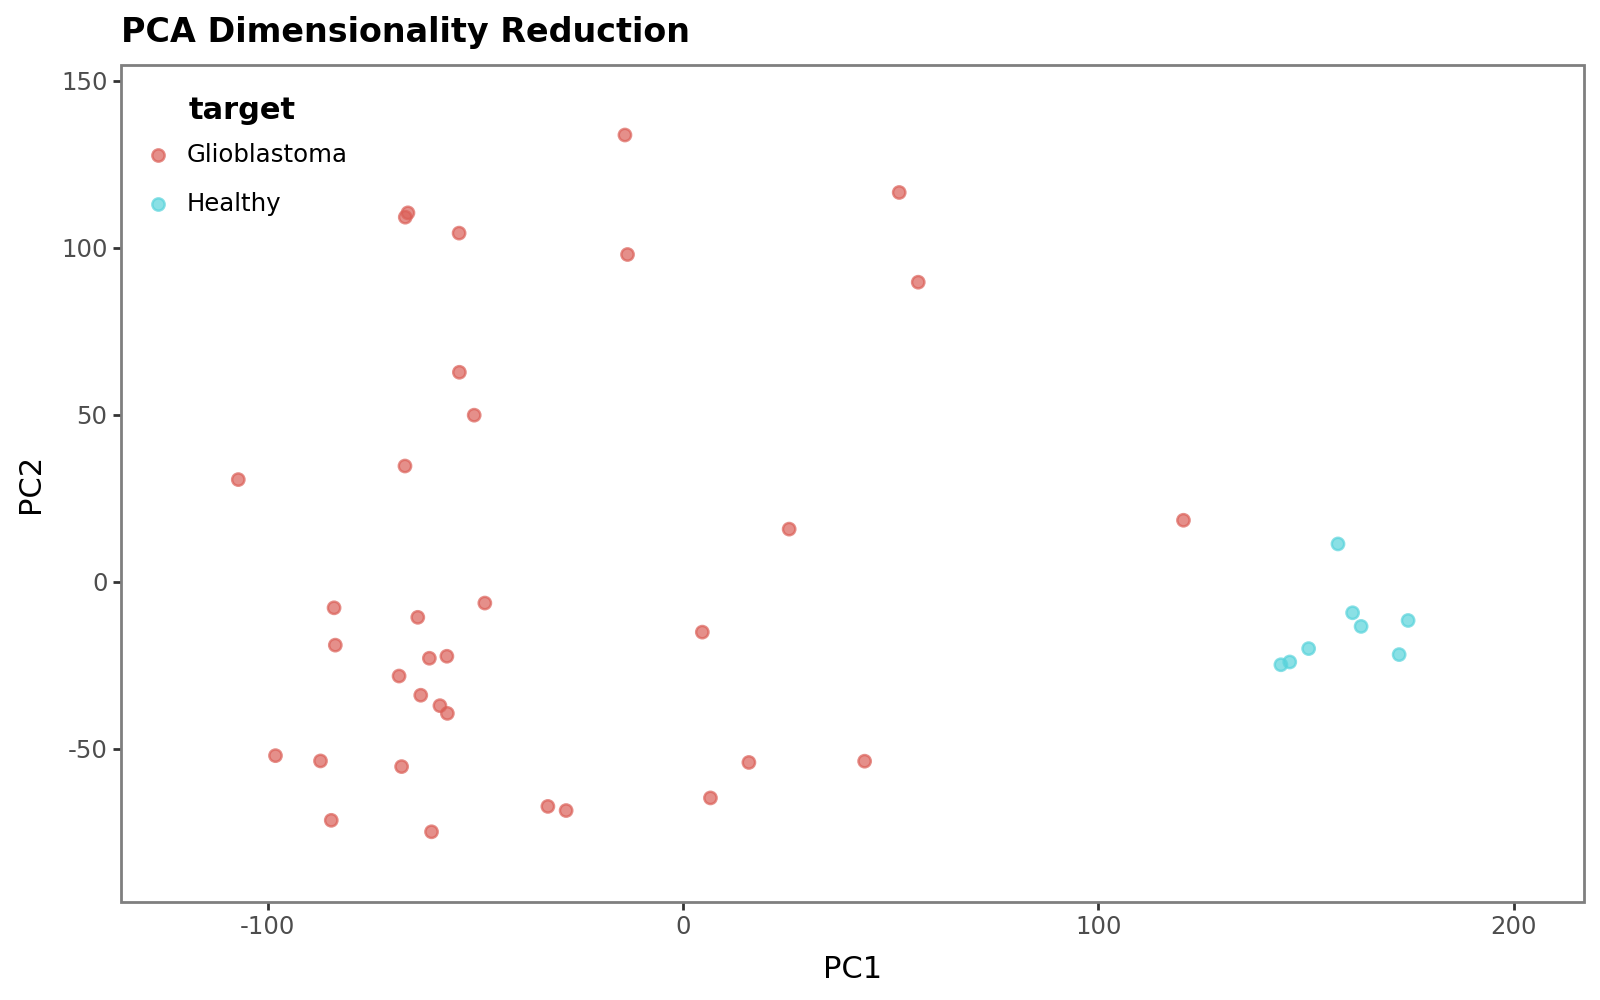

In [20]:
plot_PCA(gene_counts, reduction_type='pca', labels=metadata['class'])

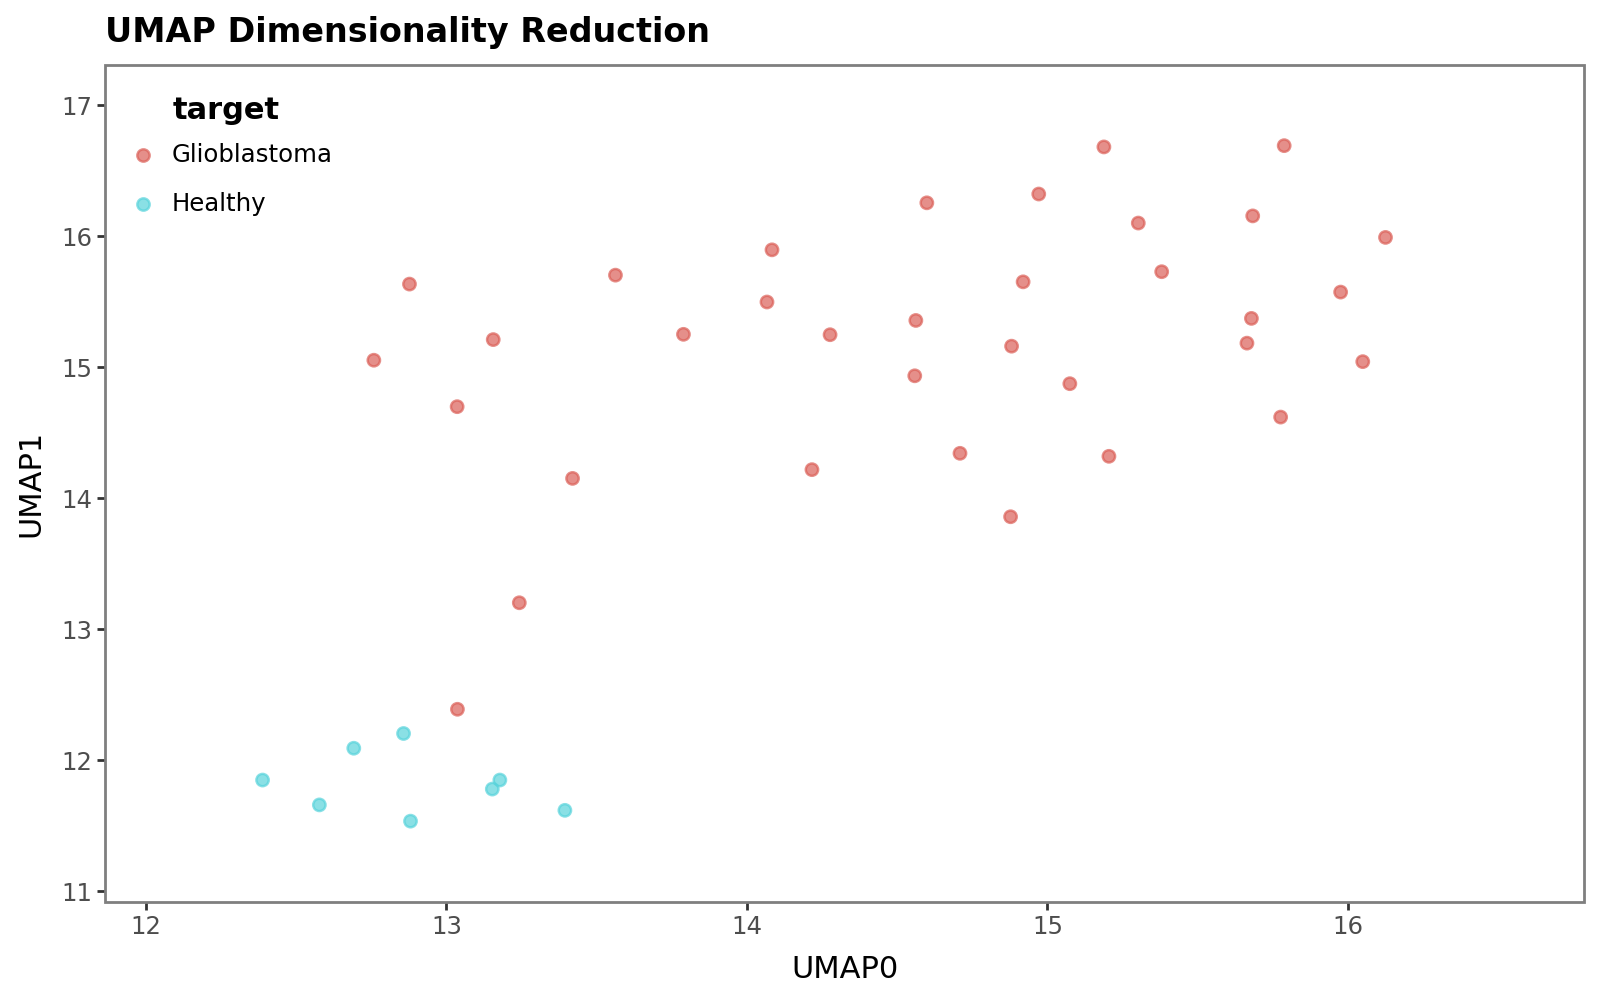

In [21]:
plot_PCA(gene_counts, reduction_type='umaps', labels=metadata['class'])

__Decomposing along gene axis__

- From above visualisation (PCA and UMAP), we can see that both healthy and cancerous tissues can be linearly differentiated.
- In UMAP, the healthy samples cluster at the lower left side of the components, while the diseased cluster around the middle zone.
- In PCA, the healthy samples cluster at the lower right of the components while the diseased samples around the other directions in the 2D-space
- Similarly, in both methods, one diseased sample lies closer to the normal brain tissue samples. This may indicate the degree of cancer state.

Next, we will cluster these genes and determine the optimal number of clusters. We will use the KMeans clustering method.

In [22]:
def run_optimal_clusters(df, n_clusters=15, scale=True, decompose=False, 
                         variance_cutoff:Union[int,float]=0.95,
                         axis_name:Literal['gene', 'sample']='sample',
                         dist_type:Literal['cosine', 'euclidean', 'correlation', None]=None):
    n_clusters = n_clusters
    sil_scores = []
    # reduce number of dimensions
    X = df.copy()

    if decompose:
        X = reduce_dimensions(X, n_components=variance_cutoff, reduction_type='pca')
        print('Number of components capturing {:.0f}% variance is {}'.format(100*variance_cutoff, X.shape[1]))
    if scale:
        X = preprocessing.scale(X)
    
    if axis_name == 'gene':
        X = X.T

    if len(X) < n_clusters:
        n_clusters = min(len(X), n_clusters)

    for i in tqdm(range(2, n_clusters+1)):
        if dist_type == 'euclidean':
            res = cluster.AgglomerativeClustering(i, linkage='ward', metric=dist_type)
        elif dist_type is None:
            res = cluster.KMeans(i, max_iter=500, n_init=10)
        elif dist_type != 'euclidean':
            res = cluster.AgglomerativeClustering(i, linkage='average', metric=dist_type)
        res.fit(X)
        sil_scores.append(metrics.silhouette_score(X, res.labels_))

    # visualise
    fig, ax = plt.subplots(1, figsize=(8,4.5))
    ax.plot(list(range(2,n_clusters+1)), sil_scores, 'o-', linewidth=1.4, markersize=3)
    ax.set_xticks(range(2, n_clusters+1, 2), range(2, n_clusters+1, 2))
    ax.set_xlabel('Number of clusters')
    ax.set_title('Silhouette Method', loc='left', fontweight='bold', fontsize=10)
    ax.set_ylabel('Silhouette scores', fontweight='bold')
    fig.tight_layout()
    plt.show()

In [23]:
def plot_dendrogram(df, scale=True, method='ward', metric='euclidean', 
                    axis_name:Literal['gene', 'sample']='sample'):
    if scale:
        X = preprocessing.scale(df, axis=0)
    if axis_name == 'gene':
        X = X.T
    
    plt.figure(figsize=(8,4.5))
    dendrogram(linkage(X, method='ward', metric='euclidean'))
    plt.title('Hierarchical Clustering', loc='left', fontweight='bold')
    plt.ylabel('Distances')
    plt.xlabel(axis_name.title()+'s')
    if axis_name == 'sample':
        plt.xticks(rotation=0, fontsize=7)
    else:
        plt.xticks([], rotation=0, fontsize=7)
    plt.show()

100%|██████████| 14/14 [00:01<00:00,  8.07it/s]


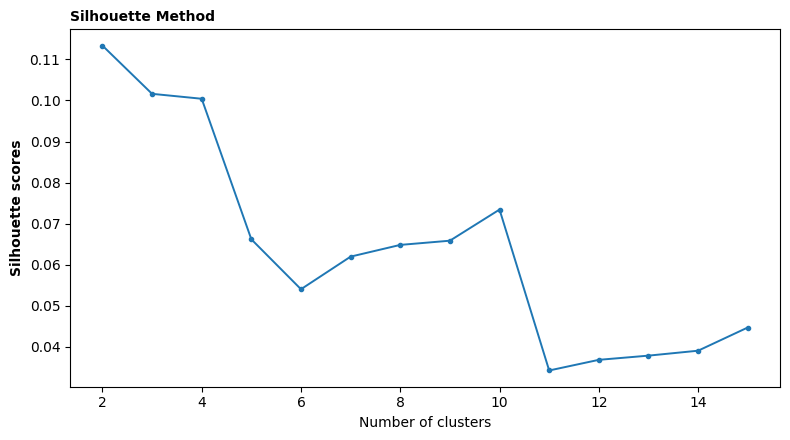

In [24]:
run_optimal_clusters(gene_counts, scale=True, dist_type='correlation')

Number of components capturing 95% variance is 36


100%|██████████| 14/14 [00:00<00:00, 14.83it/s]


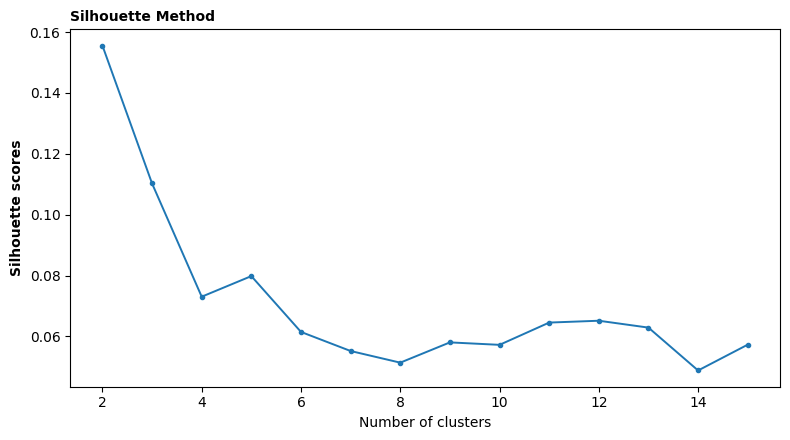

In [25]:
run_optimal_clusters(gene_counts, decompose=True, scale=False)

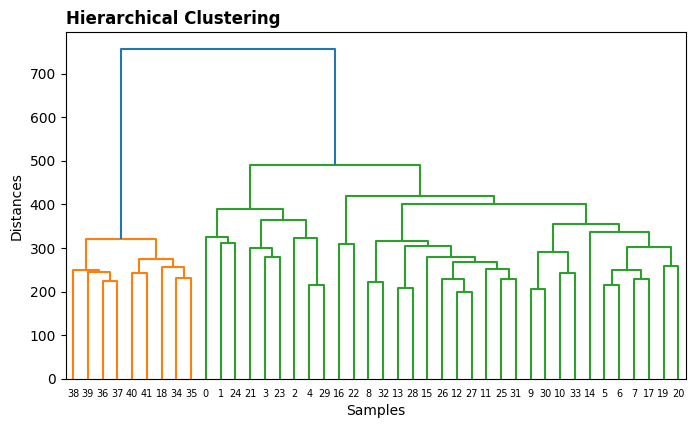

In [26]:
plot_dendrogram(gene_counts)

- By using the silhouette method to determine the optimal number of clusters, two clusters had higher silhouette scores.
- Similarly from hierarchical clustering, two clusters were obtained when the distance is cut at about 500 (using the ward linkage and euclidean distance metric)
- We will therefore cluster the data into two groups

In [27]:
def cluster_genes(
        df:pd.DataFrame, 
        n_clusters:int=2,
        decompose:bool=False,
        variance_cutoff:Union[int,float]=0.95,
        scale:bool=True,
        cluster_type:Literal['gene', 'sample']='sample',
        plot=False
        ):
    """
    Clusters genes using Hierarchical Agglomerative clustering. 

    :param df: Pandas DataFrame
    :param n_cluster: Number of clusters
    :param decompose: Apply PCA to decompose features into Principal components
    :param variance_cutoff: Percentage variance captured by principal components (PCs)
    :param scale: To scale data (Standardisation)
    :param cluster_type: If clustering should be done along sample or gene axis
    """
    X = df.copy()
    # reduce dimensions
    if decompose:
        X = reduce_dimensions(X, n_components=variance_cutoff)
        print('Number of components capturing {:.0f}% variance is {}'.format(100*variance_cutoff, X.shape[1]))
    if scale:
        X = preprocessing.scale(X, axis=0)

    if cluster_type == 'gene':
        X = X.T
        
    # fit cluster
    res = cluster.AgglomerativeClustering(n_clusters, metric='euclidean', linkage='ward')    
    res.fit(X)
    labels = res.labels_
    labels = list(map(lambda x: f'cluster {x+1}', labels))
    
    # visualise data using pca
    if plot:
        plot_PCA(X, decompose=True, labels=labels)
    else:
        return labels

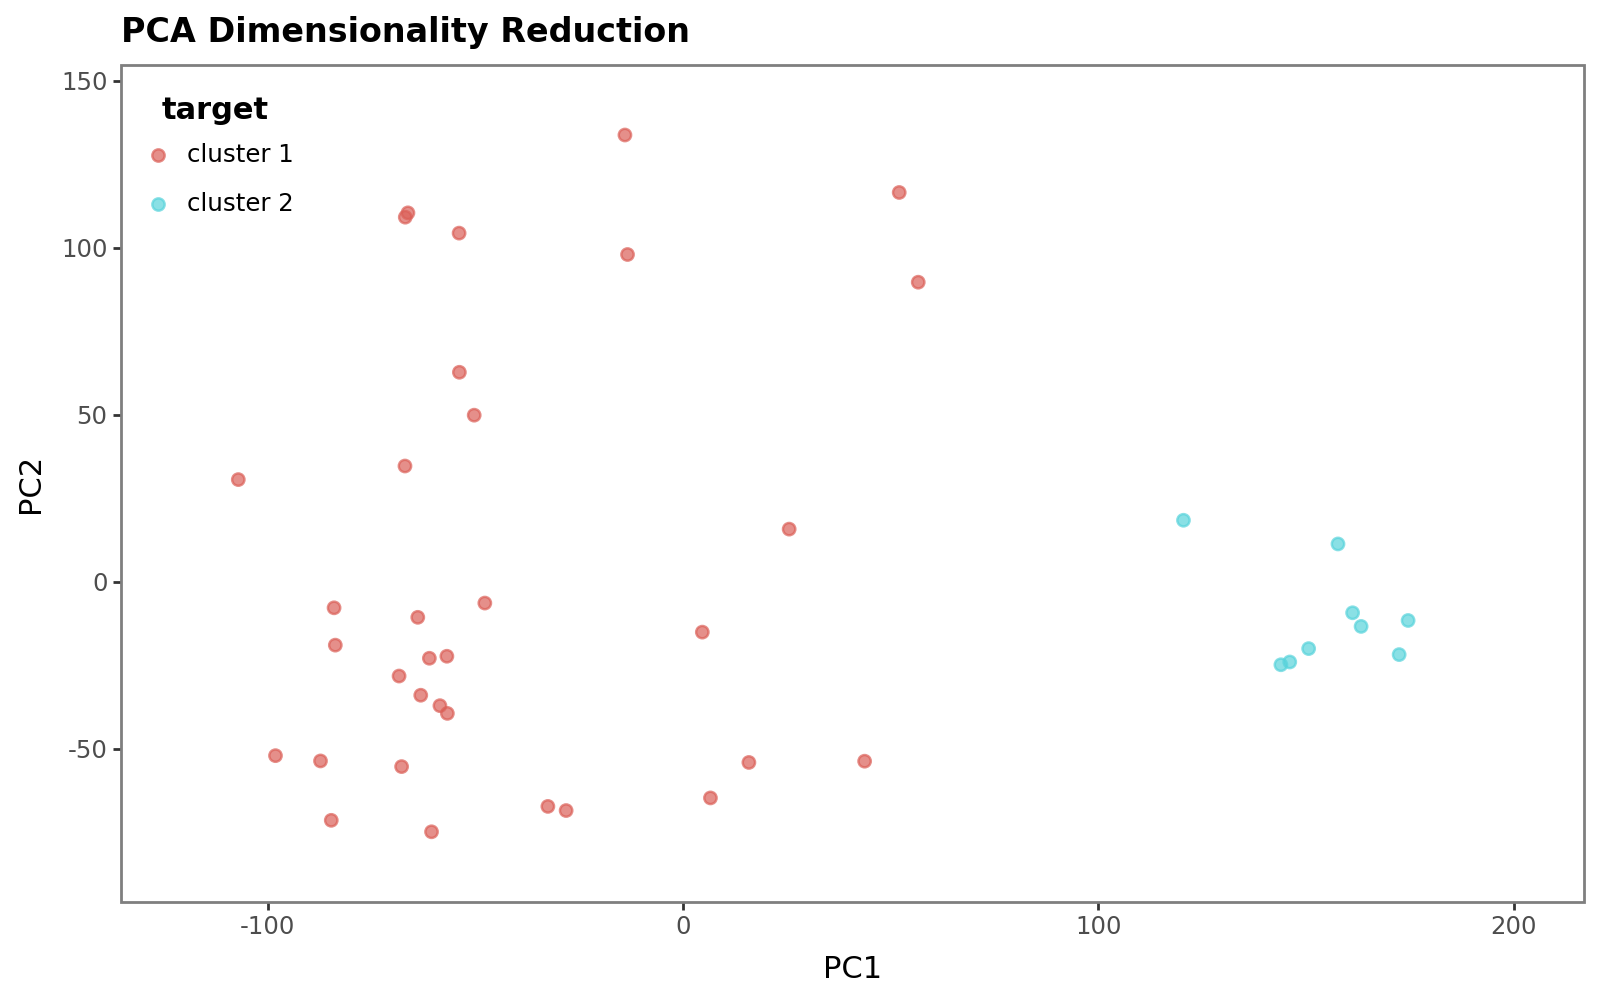

In [28]:
cluster_genes(gene_counts, plot=True)

__Differential Gene Analysis__

Here, we will perform differential gene expression to determine which genes are upregulated in cancer (glioblastoma). We will use two methods, the T-test statistical test and linear regression model.

In [29]:
def plot_volacano(deg_res:pd.DataFrame):
    if not isinstance(deg_res, pd.DataFrame):
        raise TypeError ('deg_res must be a Pandas DataFrame')
    
    # get the negative log of pval and color to map differentially expressed genes
    deg_res['neg_log_pval'] = -np.log10(deg_res['padj'])
    color = np.where(
        (deg_res['padj'] < 0.05) & (deg_res['Log2FC'] > 2), 'Up', 
        np.where((deg_res['padj'] < 0.05) & (deg_res['Log2FC'] < -2), 
                 'Down', 'Insig'))
    
    fig = (
        pn.ggplot(deg_res, pn.aes(x='Log2FC', y='neg_log_pval', color=color)) +
        pn.geom_point(alpha=0.5) +
        pn.geom_vline(xintercept=0, linetype='dashed', alpha=0.4) + 
        pn.theme_bw() +
        pn.theme(legend_position='inside', 
                 legend_position_inside = (0.93, 0.96),
                 legend_title = pn.element_text(hjust=0.5, face='bold'),
                 panel_grid=pn.element_blank(),
                 legend_key=pn.element_blank(), 
                 plot_title=pn.element_text(face='bold', hjust=0, size=11)) +
        pn.labs(title='Volcano Plot', color='DEG class', x=r'Log$_{2}$FC', y='-Log$_{10}$ padj') + 
        pn.scale_x_continuous(expand=(0.1, 0.15, 0.15, 0.1)) +
        pn.scale_y_continuous(expand=(0.1, 0.1, 0.1, 0.1)) +
        pn.scale_color_manual(values=('seagreen', 'black', 'crimson'))
    )
    fig.show()

In [30]:
def get_groups(genes, targets):
    groups_dict = {}
    unique_targets = np.unique(targets)
    for i in unique_targets:
        groups_dict[i] = genes.values[targets == i]
    return groups_dict

In [31]:
def calc_LFC(genes:pd.DataFrame, targets:Union[pd.DataFrame, pd.Series], pos_label:str=None):
    subtract = np.vectorize(lambda x,y: x - y) # calculates log2 fold change
    
    # get group datasets
    gene_names = genes.columns.tolist()
    grouped_data = get_groups(genes, targets)
    groups = list(grouped_data.keys()) # get target class names

    # get genes mean values for each class
    grouped_mean_vals = np.column_stack(list(map(lambda x: np.mean(x, axis=0), grouped_data.values())))
    grouped_mean_vals = pd.DataFrame(grouped_mean_vals, columns=groups)

    if pos_label:
        pos_label = pos_label.title()
        # sort based on user's target class of interest
        groups = [pos_label] + [i for i in groups if i != pos_label]
    
    # reverse by positive label (label of interest)
    grouped_mean_vals = grouped_mean_vals[groups]

    # stack to calculate Log2 fold change 
    # [[test, control] for all genes] -> length equals number of genes
    grouped_mean_vals = [grouped_mean_vals.iloc[:, i] \
                         for i in range(grouped_mean_vals.shape[1])]
    
    # get log2FC
    LFC = subtract(*grouped_mean_vals)
    return LFC, grouped_data, gene_names

In [32]:
def run_OLS(genes:pd.DataFrame, 
            target:pd.Series, 
            pos_label:Union[str, None]=None) -> np.ndarray:
    
    def run_wald_test(model):
        if hasattr(model, 'wald_test'):
            res = model.wald_test(r_matrix='class=0', scalar=False)
            return res.pvalue

    groups = np.unique(target)
    colnames = genes.columns.tolist()

    # if class of interest, pos_label value is 1, then rearrange groups
    if pos_label and pos_label in groups:
        groups_map = {i:1 if i==pos_label else 0 for i in groups}
        groups = [pos_label] + [i for i in groups if i != pos_label]
    else:
        groups_map = {i:j for i,j in zip(groups, range(len(groups)))}
    
    X = target.map(groups_map).to_frame()
    X['intercept'] = 1 # add intercept
    y = gene_counts.reset_index(drop=True)

    fit_models = np.vectorize(lambda col: sm.GLM(y[col], X, family=sm.families.Gaussian()).fit())
    models = fit_models(colnames)
    
    pvals = np.vectorize(run_wald_test)(models)
    assert len(pvals) == len(colnames)
    return pvals

In [33]:
def DGE_analysis(genes, target, pos_label=None, method:Literal['ttest', 'lm']='ttest'):
    LFC, grouped_data, gene_names =  calc_LFC(genes, target, pos_label)
    if method == 'ttest':
        # perform stat test
        if len(grouped_data.keys()) == 2:
            _, pval = stats.ttest_ind(*grouped_data.values())
        else:
            print('Number of groups must be 2')
            exit()
    elif method == 'lm':
        pval = run_OLS(genes, target, pos_label)
    else:
        print(f'{method} not recognised!')
        exit(1)

    _, adj_pval, _, _ = multipletests(pval, method='fdr_bh')
    result = pd.DataFrame(np.c_[LFC, pval, adj_pval], 
                          index=gene_names, 
                          columns=['Log2FC', 'pval', 'padj'])
    
    assert len(result) == len(gene_names)
    result = result.sort_values(['padj', 'Log2FC'], ascending=[True, True])
    return result

__Linear Method__

In [34]:
results_lm = DGE_analysis(gene_counts, metadata['class'], pos_label='glioblastoma', method='lm')

In [35]:
results_lm

,Log2FC,pval,padj
ILMN_1797526,-1.405265,5.468893e-78,2.582903e-73
ILMN_1812824,-3.549803,8.421054e-72,1.988590e-67
ILMN_2357542,-1.815932,4.243634e-62,6.680753e-58
ILMN_3246728,-1.251171,4.653064e-55,5.493989e-51
ILMN_1666221,-1.992599,2.768462e-52,2.615033e-48
...,...,...,...
ILMN_1802821,-0.000014,9.996944e-01,9.997791e-01
ILMN_1673898,-0.000014,9.998695e-01,9.999330e-01
ILMN_1725686,-0.000004,9.999093e-01,9.999517e-01
ILMN_1751958,-0.000013,9.999324e-01,9.999535e-01


In [36]:
# selecting statistically differentially expressed genes with 2-fold change
upregulated_genes = results_lm[(results_lm.padj < 0.05) & (results_lm.Log2FC > 2)]
downregulated_genes = results_lm[(results_lm.padj < 0.05) & (results_lm.Log2FC < -2)]

In [37]:
upregulated_genes.shape, downregulated_genes.shape

((211, 3), (381, 3))

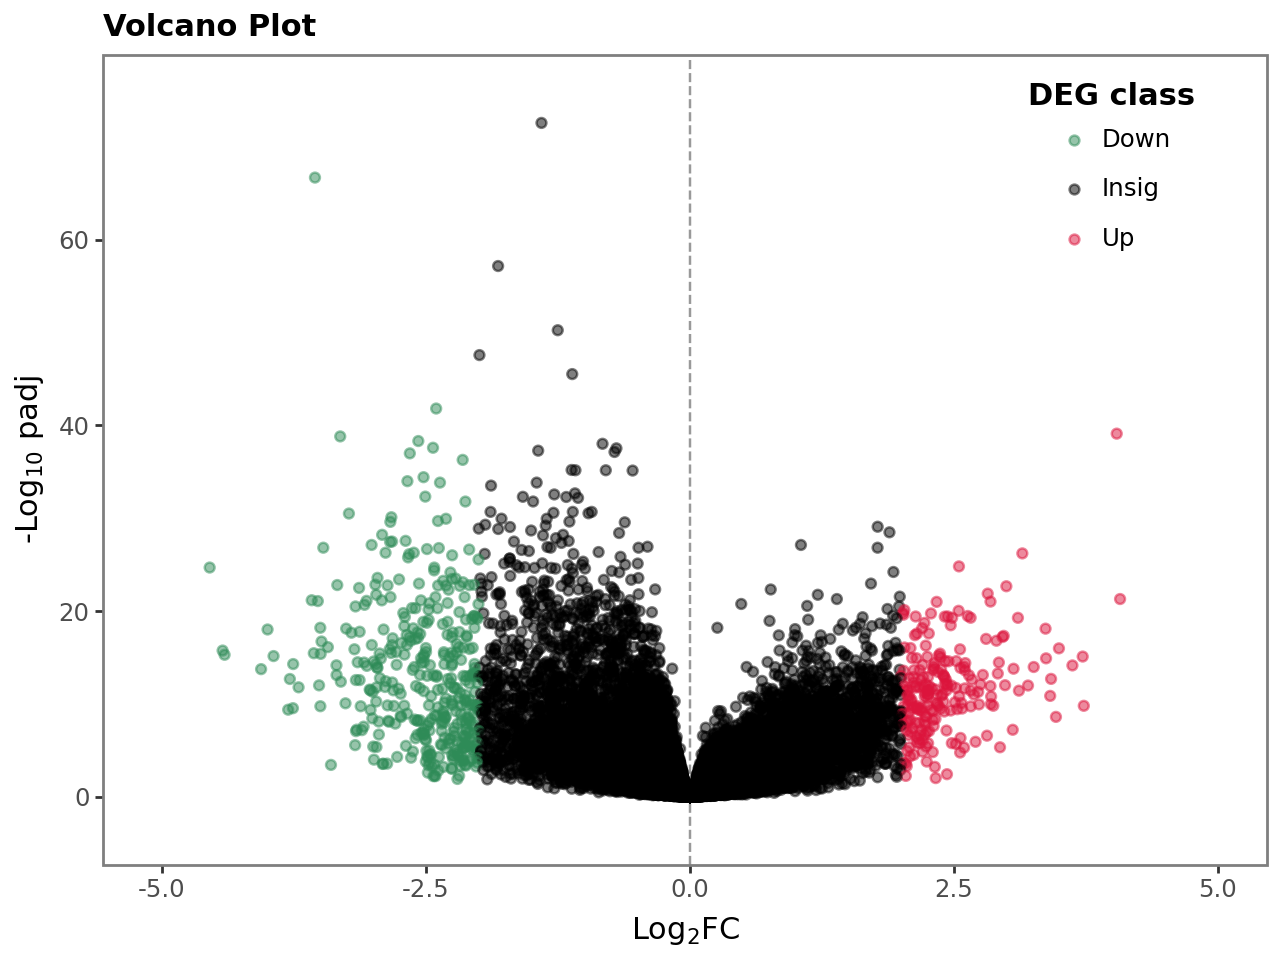

In [38]:
plot_volacano(results_lm)

- To identify differentially expressed genes, a Generalised Linear Model (GLM) with a Gaussian distribution was used. 
- The model constraint against the null hypothesis that the coefficient is zero was tested using the Wald test and their p-values returned. 
- The p-values for each gene was corrected using the False discovery ratio-Bonferroni Holm multiple comparision test. 
- After that differentially genes, with adjusted pvalue less than 0.05 and absolute log2 fold change above 2, were selected. 
- From the result, out of the over 47,000 genes, 592 genes (211 upregulated and 381 downregulated genes) were differentially expressed in disease condition (glioblastoma).
- To visualise differentially expressed genes, a volcano plot was used to show upregulated and downregulated genes

In [39]:
upregulated = upregulated_genes.index.tolist()
downregulated = downregulated_genes.index.tolist()

In [40]:
# saving upregulated and downregulated genes to a file
os.makedirs('DGE', exist_ok=True)

with open('DGE/upregulated.txt', mode='wt') as upreg_genes:
    genes = '\n'.join(upregulated)
    upreg_genes.writelines(genes)

with open('DGE/downregulated.txt', mode='wt') as downreg_genes:
    genes = '\n'.join(downregulated)
    downreg_genes.writelines(genes)

In [41]:
# selecting differentially expressed genes
deg_genes = gene_counts[upregulated + downregulated]

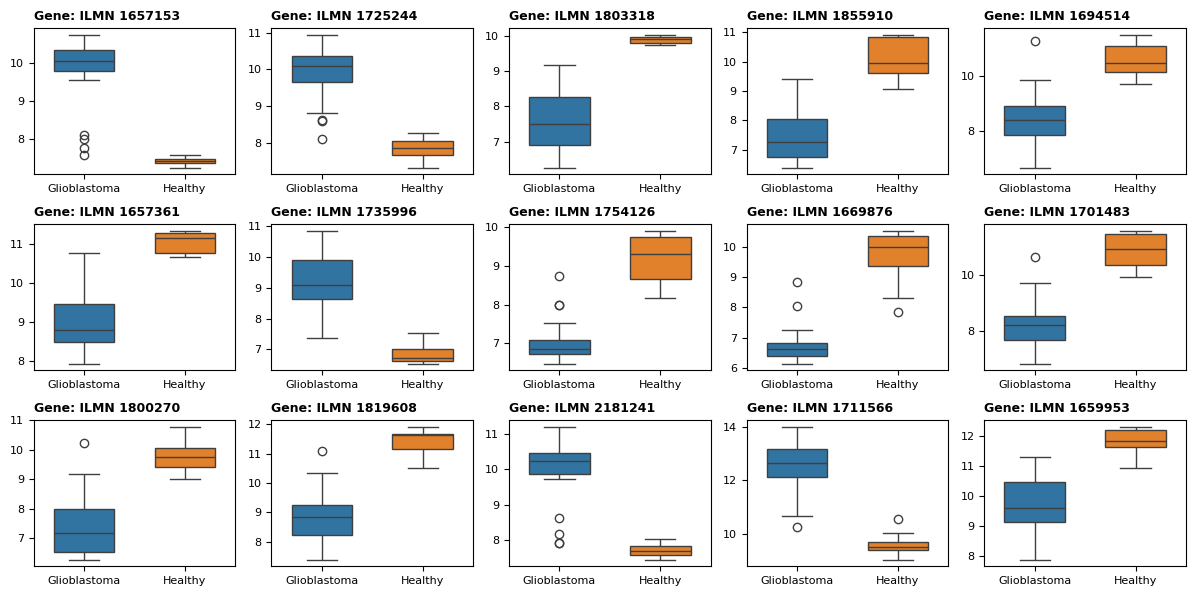

In [42]:
# plot some of the DEGs
plot_distribution(deg_genes, plot_type='box', seed=10)

__T-test method__

In [43]:
results_tt = DGE_analysis(gene_counts, metadata['class'], pos_label='glioblastoma')

In [44]:
results_tt

,Log2FC,pval,padj
ILMN_1797526,-1.405265,2.247986e-21,1.061701e-16
ILMN_1812824,-3.549803,1.026859e-20,2.424877e-16
ILMN_2357542,-1.815932,1.440255e-19,2.267394e-15
ILMN_3246728,-1.251171,1.249101e-18,1.474845e-14
ILMN_1666221,-1.992599,3.132980e-18,2.959350e-14
...,...,...,...
ILMN_1802821,-0.000014,9.996963e-01,9.997810e-01
ILMN_1673898,-0.000014,9.998703e-01,9.999338e-01
ILMN_1725686,-0.000004,9.999099e-01,9.999522e-01
ILMN_1751958,-0.000013,9.999328e-01,9.999540e-01


In [45]:
# selecting statistically differentially expressed genes with 2-fold change
print('Upregulated Genes: ', sum((results_tt.padj < 0.05) & (results_tt.Log2FC > 2)))
print('Downregulated Genes: ', sum((results_tt.padj < 0.05) & (results_tt.Log2FC < -2)))

Upregulated Genes:  211
Downregulated Genes:  381


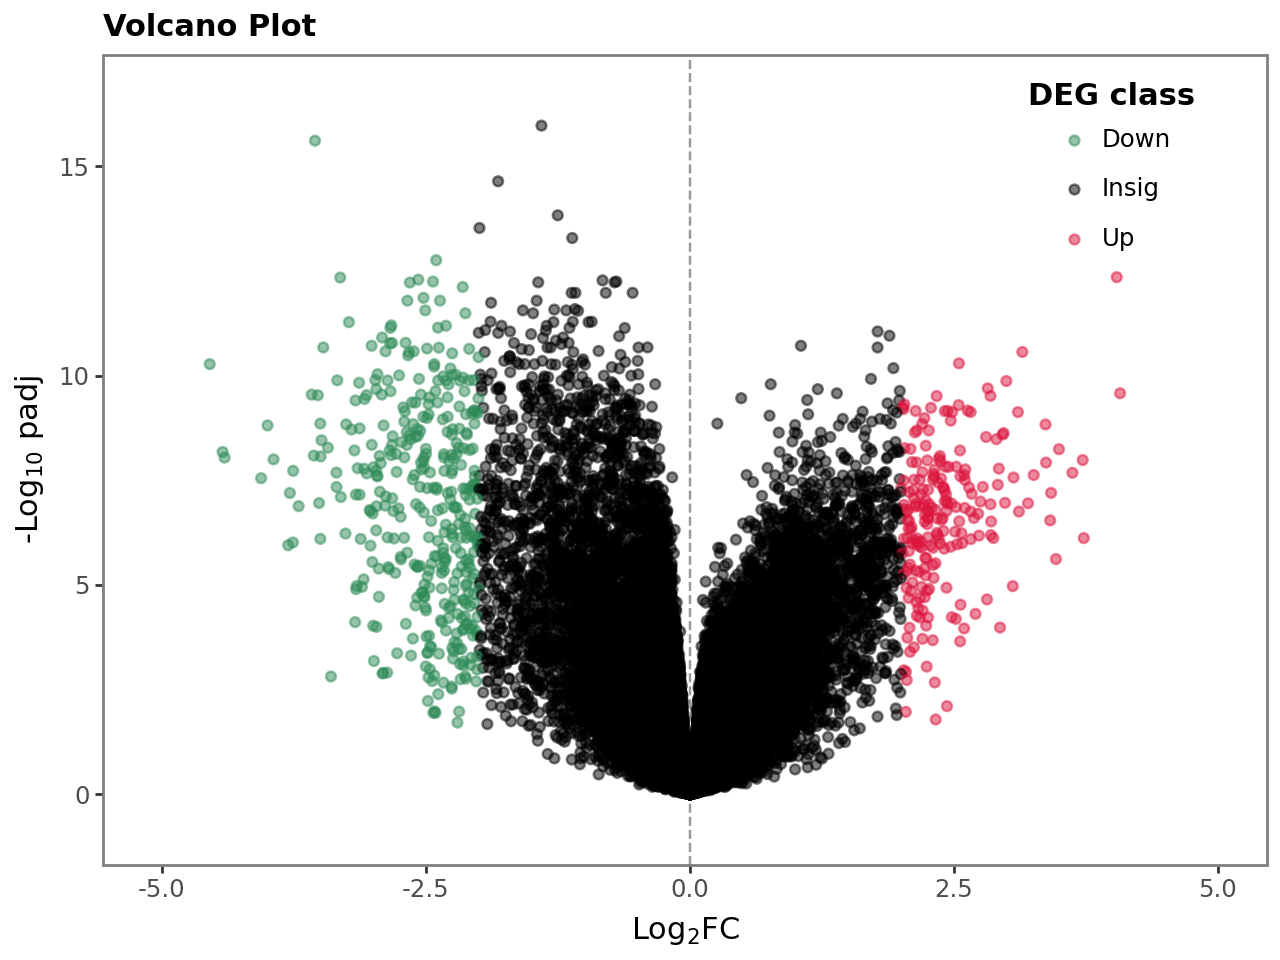

In [46]:
plot_volacano(results_tt)

__Clustering genes to find similarities and differences__

Here, we will cluster the differentially expressed genes separately to identify any similarity or difference between genes in each cluster. Firstly, we will run a hierarchical clustering algorithm to determine the optimal number of clusters in the data. After that, we will visualise these genes by their clusters using PCA dimensionality reduction. 

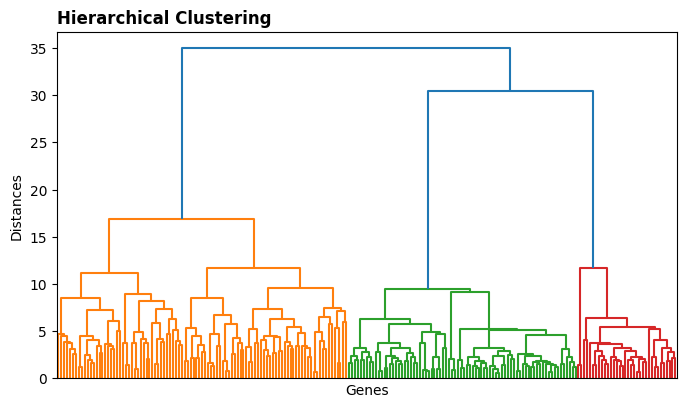

In [47]:
plot_dendrogram(deg_genes[upregulated], axis_name='gene')

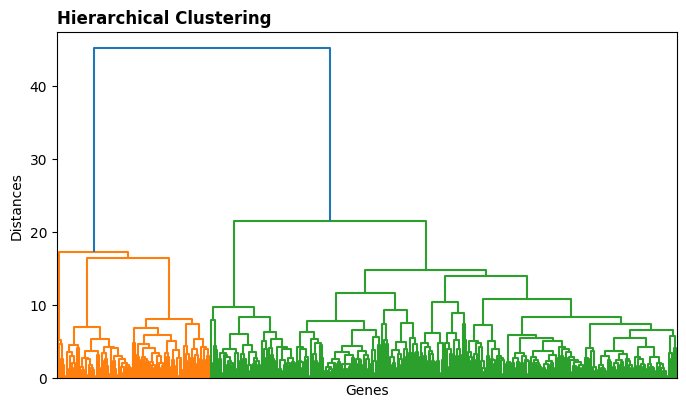

In [48]:
plot_dendrogram(deg_genes[downregulated], axis_name='gene')

- By clustering upregulated and downregulated differentially expressed genes, we find out that three clusters can be obtained from the upregulated genes while from downregulated genes, the likely optimal number of genes would be two

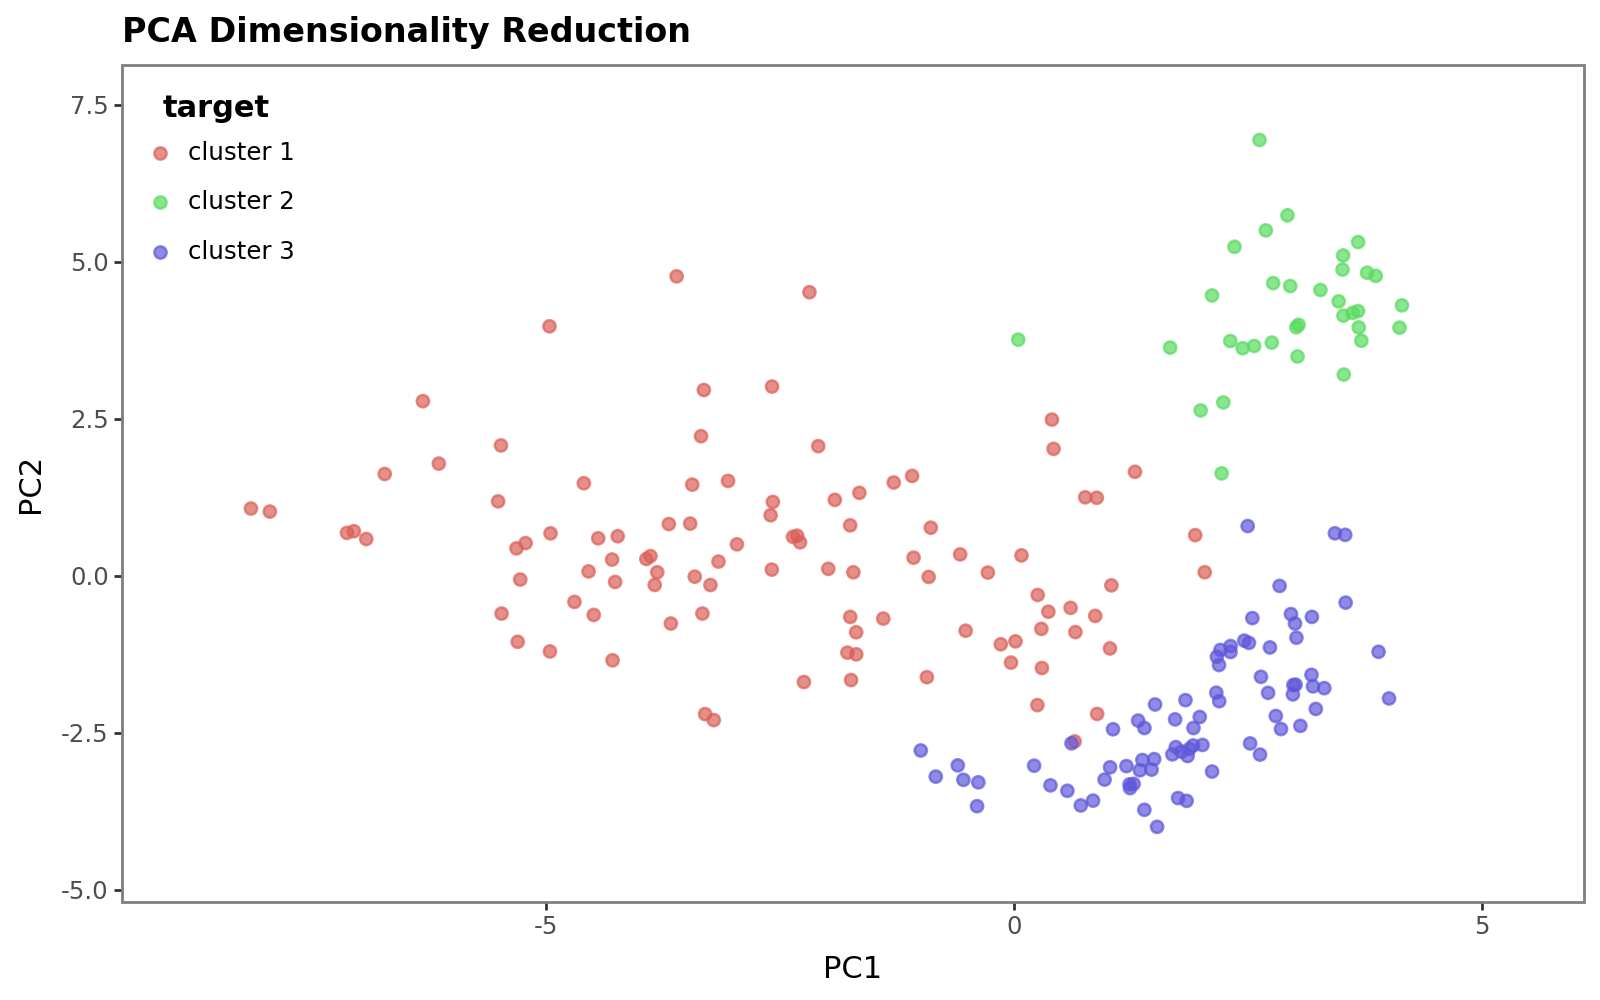

In [49]:
# upregulated genes
cluster_genes(deg_genes[upregulated], 3, cluster_type='gene', plot=True)

- There are some distinctions between genes in each cluster and some overlaps between cluster 1 and 3 and between 1 and 2

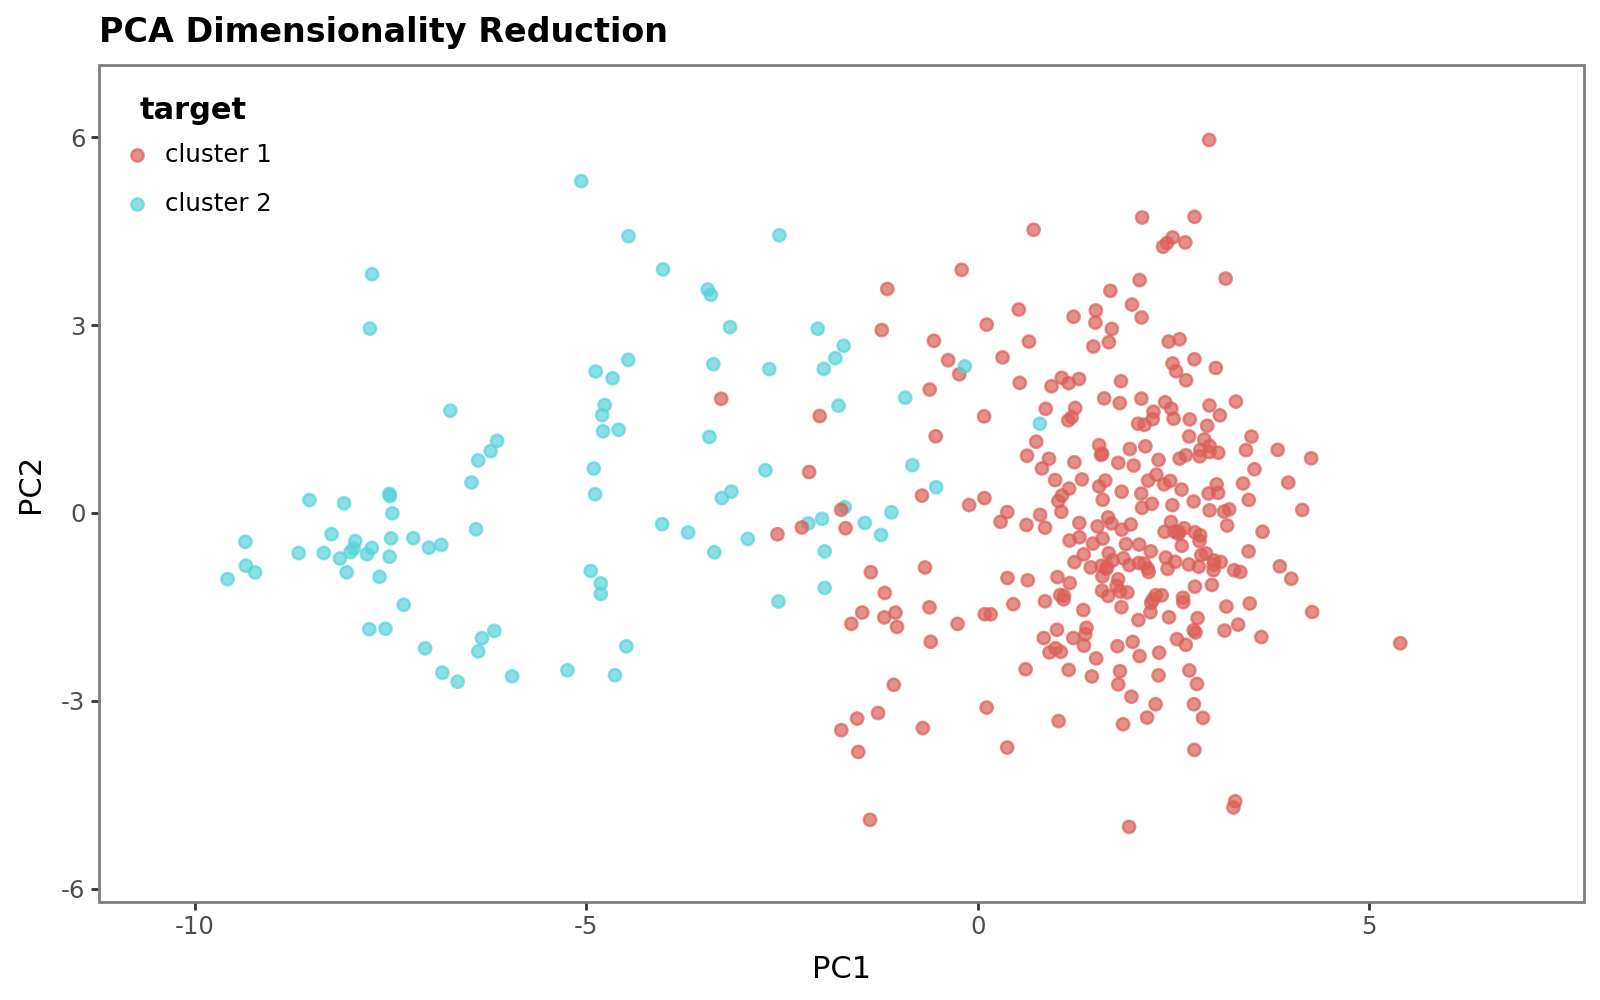

In [50]:
# downregulated genes
cluster_genes(deg_genes[downregulated], 2, cluster_type='gene', plot=True)

- Overlap in some upregulated genes

## Functional Analysis

In this section, we will perform a functional annotation of our upregulated and downregulated genes. These include Gene Ontology (GO) analysis and pathway analysis. In the GO analysis, we will identify the biological processes these genes are involved in (biological processes), the molecular activities of their gene products (Molecular function), and the location of these gene products inside the cell (cellular component). In the pathway analysis, we will map genes to known biological pathways to understand how genes interact within larger biological systems.

For both GO and pathway analyses, there are databases that are used to do that. Some of these databases include, KEGG (Kyoto Encyclopaedia of Genes and Genomes) database, DAVID (Database for Annotation, Visualisation and Integrated Discovery), Ingenuity Pathway Analysis (IPA), Enrichr, GSEA, Reactome databases etc. With the enrichr database, we can query across multiple databases. For this purpose, we will be using a the GSEApy package in Python which has an enrichr wrapper for querying enrichr database.

In [51]:
# library/database names in gseapy
lib_names = pd.Series(gspy.get_library_name(), name='library_names')

In [52]:
len(lib_names)

227

In [53]:
def get_functional_results(gene_list, gene_set, organism='Human', outdir=None, cutoff=None):
    """
    Queries and gets functional annotation of genes in an organism from a given database

    :param gene_list (str, list, pd.DataFrame, np.ndarray): List of genes to query from functional annotation database
    :param gene_set (list, str): string or list of annnotation database to query
    :param organism: Type of organism to query from database
    :param description: Description to describe query 
    :param outdir: Output directory to save query data
    :param cutoff: cutoff for adjusted p-value
    """
    if cutoff:
        result = gspy.enrichr(gene_list=gene_list, gene_sets=gene_set, 
                              organism=organism, cutoff=cutoff, outdir=outdir)
    else:
        result = gspy.enrichr(gene_list=gene_list, gene_sets=gene_set, 
                              organism=organism, outdir=outdir)

    return result

__Get gene IDs of Illumina probes__

In [54]:
bm = gspy.Biomart()

In [55]:
# get biomart attributes
f = bm.get_attributes()

In [56]:
with open('DGE/attribute_names.txt', 'wt') as file:
    names = '\n'.join(np.sort(f.Attribute.unique()).tolist())
    file.writelines(names)

In [57]:
# select those with illumina
f[f.Attribute.str.contains('illumina', regex=True, case=False)]

,Attribute,Description,Additional
132,illumina_humanref_8_v3,ILLUMINA HumanRef 8 V3 probe,
133,illumina_humanwg_6_v3,ILLUMINA HumanWG 6 V3 probe,


In [58]:
# get gene names of Illumina IDs
def get_gene_ids(gene_list):
    gene_ids1 = bm.query(dataset='hsapiens_gene_ensembl', 
                        attributes=['illumina_humanref_8_v3', 'external_gene_name'], 
                        filters={'illumina_humanref_8_v3': gene_list}
                        ).rename({'illumina_humanref_8_v3':'probe_id'}, axis=1)

    gene_ids2 = bm.query(dataset='hsapiens_gene_ensembl', 
                        attributes=['illumina_humanwg_6_v3', 'external_gene_name'], 
                        filters={'illumina_humanwg_6_v3': gene_list}
                        ).rename({'illumina_humanwg_6_v3' : 'probe_id'}, axis=1)

    gene_ids = pd.concat([gene_ids1, gene_ids2]).dropna().drop_duplicates()
    return gene_ids

In [59]:
def save_annotation_file(annotation_result, filename, folder_name=None, cutoff=0.05):
    """
    Saves result of functional annotation data

    :param annotation_result: Result of annotated data
    :param filename: filename
    :param folder_name: folder name to save file
    :param cutoff: adjusted p-value cutoff 
    """
    if folder_name:
        filepath = os.path.join(path, folder_name, filename+'.csv')
    else:
        filepath = os.path.join(path, filename)

    if hasattr(annotation_result, 'results'):
        result = annotation_result.results

    if cutoff:
        result = result[result['Adjusted P-value'] < cutoff]

    with open(filepath, 'wt') as file:
        csv_writer = csv.writer(file, lineterminator='\r')
        csv_writer.writerow(result.columns.tolist())
        csv_writer.writerows(result.values.tolist())

In [60]:
def plot_figure(annotation_result, title=None):
    fig = gspy.barplot(annotation_result.res2d, title=title)
    plt.yticks(fontsize=9)
    plt.xticks(fontsize=9)
    plt.xlabel(fig.get_xlabel(), fontsize=10)
    plt.title(fig.get_title(), fontweight='bold', fontsize=15);

In [61]:
# get gene ids
gene_ids_up = get_gene_ids(upregulated)
gene_ids_down = get_gene_ids(downregulated)

In [62]:
# save to file
gene_ids_down.to_csv('DGE/downregulated_gene_names.csv', index=False)
gene_ids_up.to_csv('DGE/upregulated_gene_names.csv', index=False)

In [63]:
print('Number of gene names in upregulated genes: {}'.format(gene_ids_up.external_gene_name.nunique()))
print('Number of gene names in downregulated genes: {}'.format(gene_ids_down.external_gene_name.nunique()))

Number of gene names in upregulated genes: 153
Number of gene names in downregulated genes: 325


Number of upregulated genes with gene ID names is 152/211 while downregulated genes has 325/381

### Functional Annotation

In [64]:
upregulated_gene_ids = gene_ids_up.external_gene_name.unique().tolist()
downregulated_gene_ids = gene_ids_down.external_gene_name.unique().tolist()

__Biological Processes__

In [65]:
enr_GO_upreg = get_functional_results(gene_list=upregulated_gene_ids, 
                                      gene_set='GO_Biological_Process_2023')

enr_GO_downreg = get_functional_results(gene_list=downregulated_gene_ids,
                                        gene_set='GO_Biological_Process_2023')

In [66]:
save_annotation_file(enr_GO_upreg, 'Bio_process_upreg', 'DGE/annotation_result', None)
save_annotation_file(enr_GO_downreg, 'Bio_process_downreg', 'DGE/annotation_result', None)

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




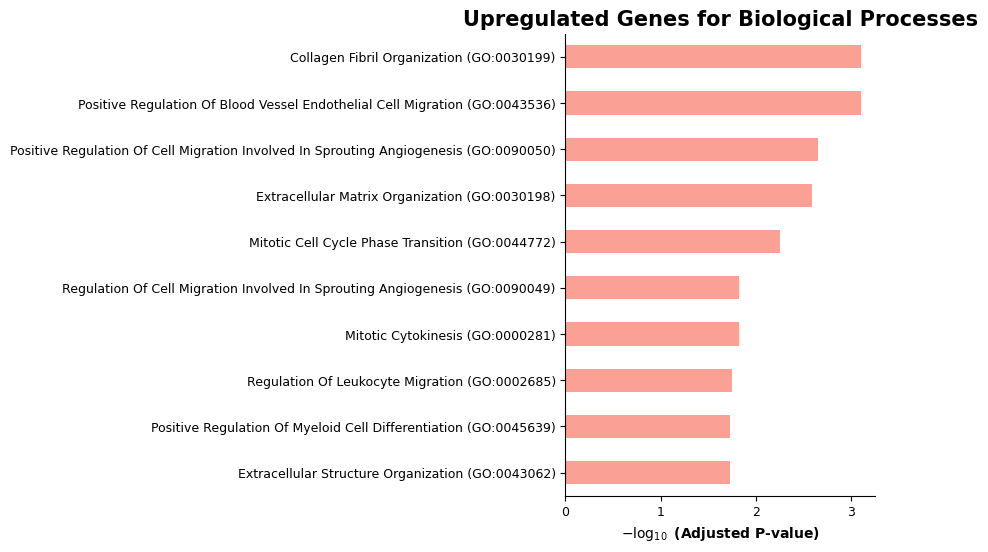

In [67]:
plot_figure(enr_GO_upreg, title='Upregulated Genes for Biological Processes')

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




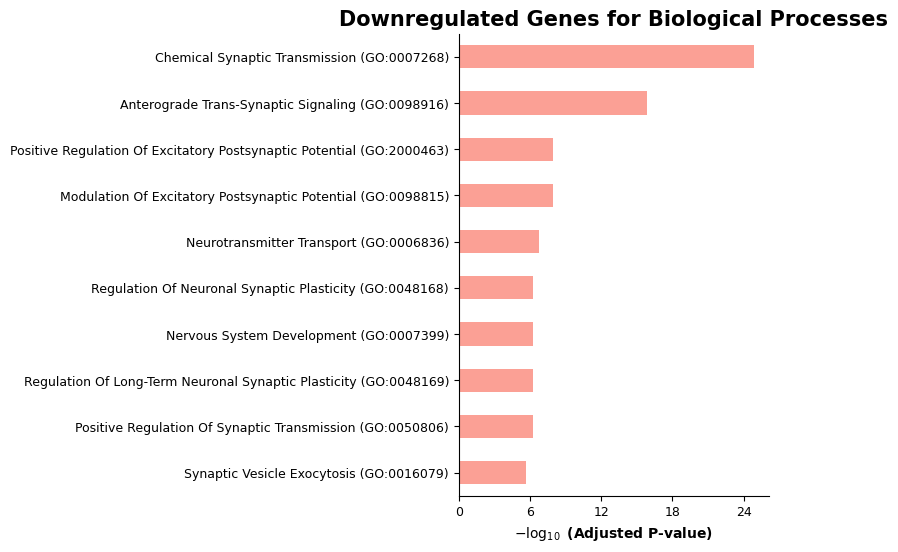

In [68]:
plot_figure(enr_GO_downreg, title='Downregulated Genes for Biological Processes')

__Molecular function__

In [69]:
enr_MF_upreg = get_functional_results(gene_list=upregulated_gene_ids, 
                                      gene_set='GO_Molecular_Function_2023')

enr_MF_downreg = get_functional_results(gene_list=downregulated_gene_ids, 
                                        gene_set='GO_Molecular_Function_2023')

In [70]:
save_annotation_file(enr_MF_upreg, 'Molecular_func_upreg', 'DGE/annotation_result', None)
save_annotation_file(enr_MF_downreg, 'Molecular_func_downreg', 'DGE/annotation_result', None)

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




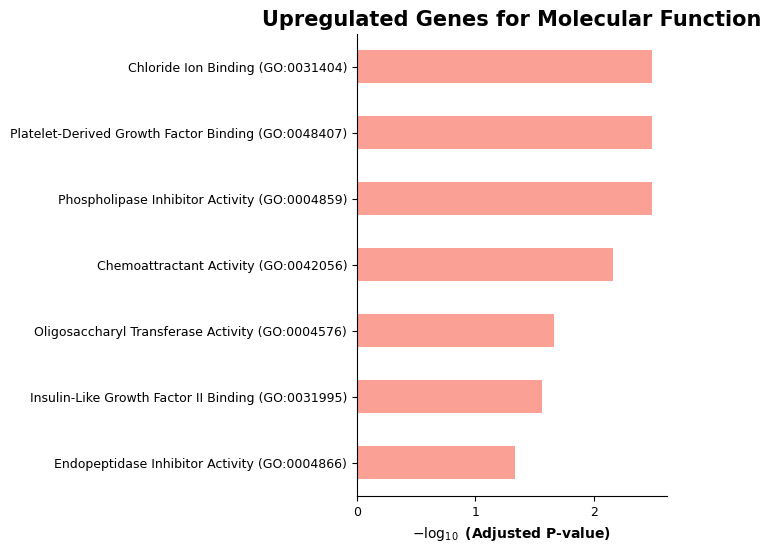

In [71]:
plot_figure(enr_MF_upreg, title='Upregulated Genes for Molecular Function')

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




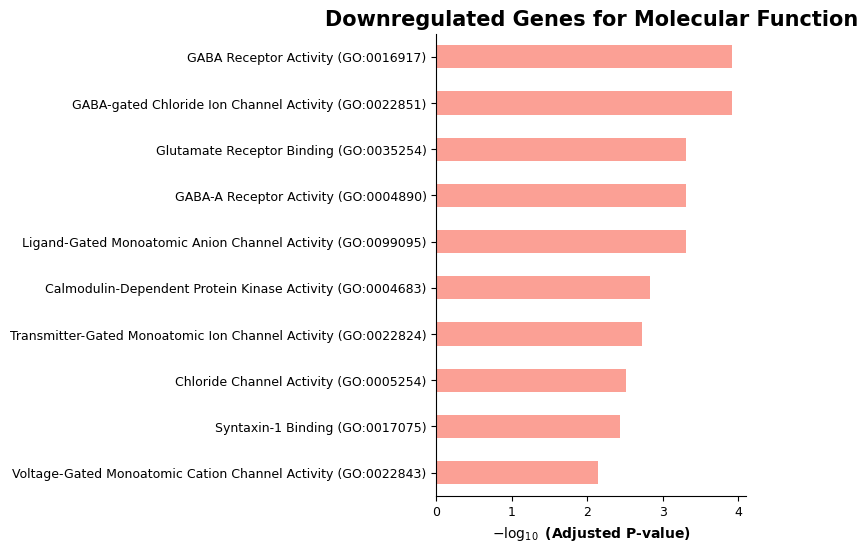

In [72]:
plot_figure(enr_MF_downreg, title='Downregulated Genes for Molecular Function')

__Cellular component__

In [73]:
enr_CC_upreg = get_functional_results(gene_list=upregulated_gene_ids, 
                                      gene_set='GO_Cellular_Component_2023')

enr_CC_downreg = get_functional_results(gene_list=downregulated_gene_ids, 
                                        gene_set='GO_Cellular_Component_2023')

In [74]:
save_annotation_file(enr_CC_upreg, 'cellular_component_upreg', 'DGE/annotation_result', None)
save_annotation_file(enr_CC_downreg, 'cellular_component_downreg', 'DGE/annotation_result', None)

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




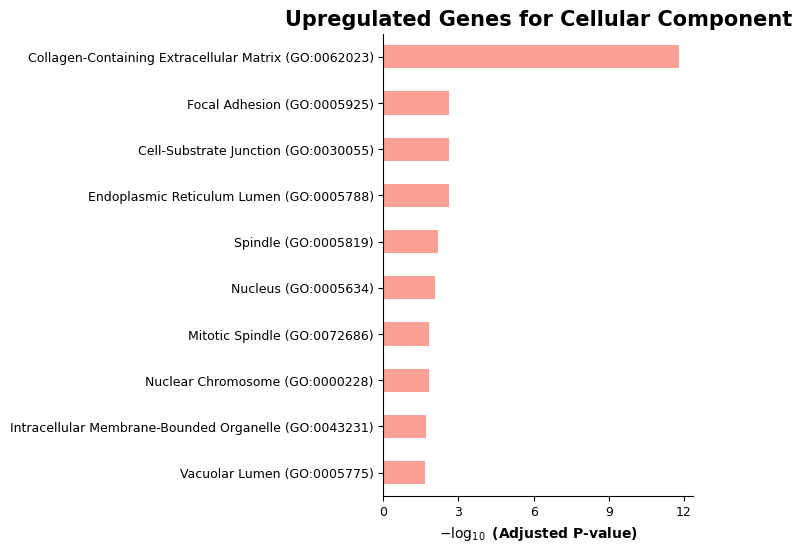

In [75]:
plot_figure(enr_CC_upreg, title='Upregulated Genes for Cellular Component')

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




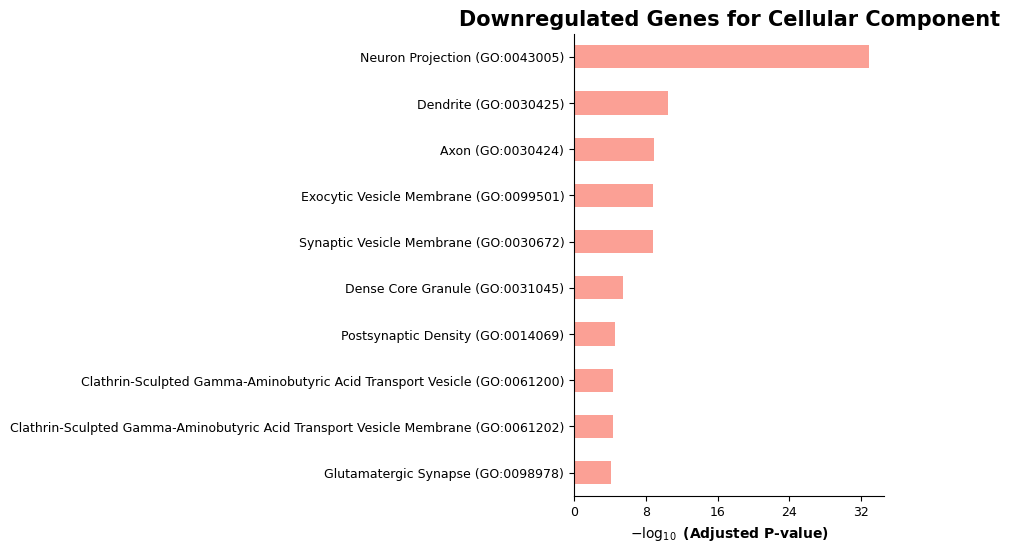

In [76]:
plot_figure(enr_CC_downreg, title='Downregulated Genes for Cellular Component')

__Pathway Analysis__

KEGG

In [77]:
enr_kegg_upreg = get_functional_results(gene_list=upregulated_gene_ids, 
                                        gene_set='KEGG_2021_Human')

enr_kegg_downreg = get_functional_results(gene_list=downregulated_gene_ids, 
                                          gene_set='KEGG_2021_Human')

In [78]:
save_annotation_file(enr_kegg_upreg, 'kegg_upreg', 'DGE/annotation_result', None)
save_annotation_file(enr_kegg_downreg, 'kegg_downreg', 'DGE/annotation_result', None)

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




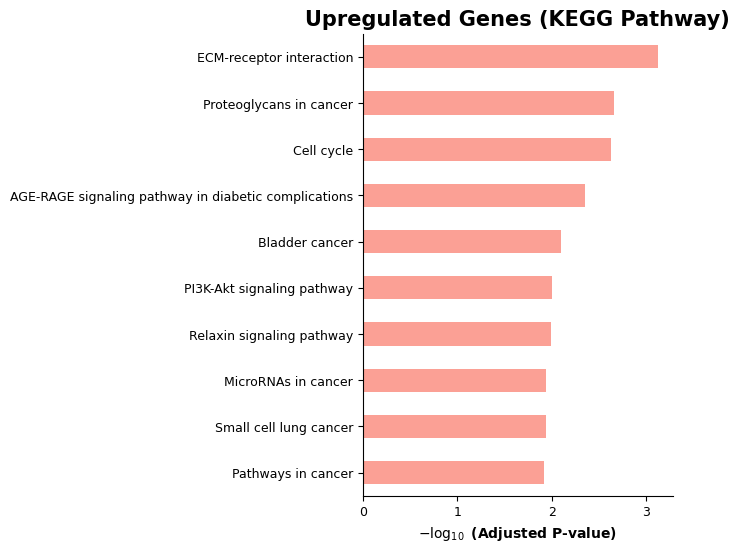

In [79]:
plot_figure(enr_kegg_upreg, title='Upregulated Genes (KEGG Pathway)')

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




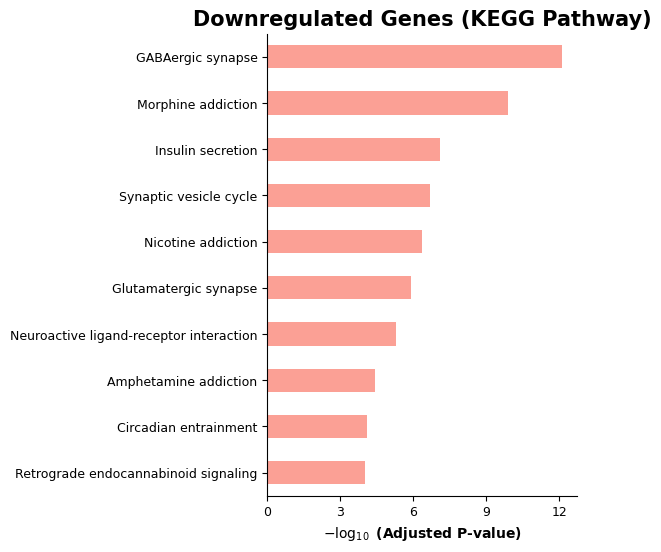

In [80]:
plot_figure(enr_kegg_downreg, title='Downregulated Genes (KEGG Pathway)')

Reactome

In [81]:
enr_reactome_upreg = get_functional_results(gene_list=upregulated_gene_ids, 
                                            gene_set='Reactome_2022')

enr_reactome_downreg = get_functional_results(gene_list=downregulated_gene_ids, 
                                              gene_set='Reactome_2022')

In [82]:
save_annotation_file(enr_reactome_upreg, 'reactome_upreg', 'DGE/annotation_result', None)
save_annotation_file(enr_reactome_downreg, 'reactome_downreg', 'DGE/annotation_result', None)

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




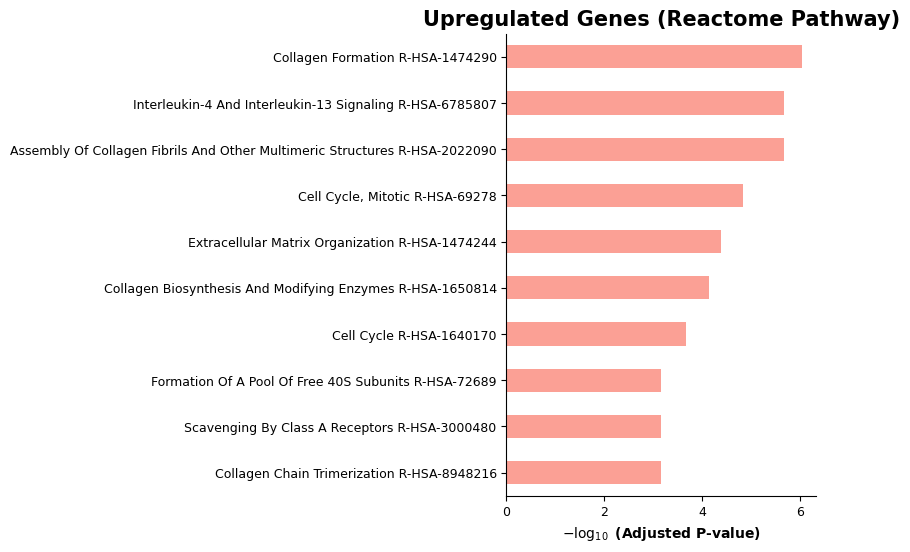

In [83]:
plot_figure(enr_reactome_upreg, title='Upregulated Genes (Reactome Pathway)')

C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
C:\Users\Chigozie\AppData\Roaming\Python\Python312\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




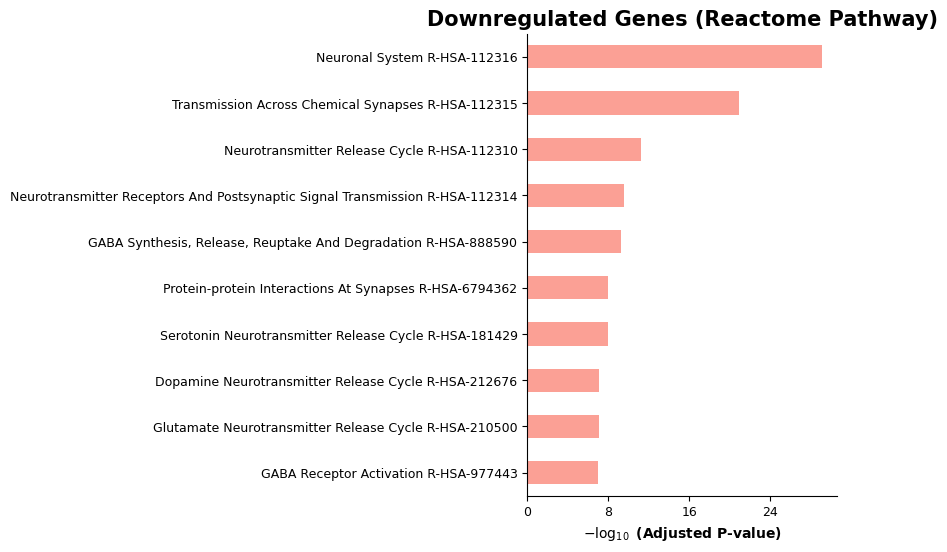

In [84]:
plot_figure(enr_reactome_downreg, title='Downregulated Genes (Reactome Pathway)')

### **Summary**

In this notebook, we analysed genes responsible for a biomarker responsible for glioblastoma cancer. We investigated genes that are upregulated and downregulated in the disease condition compared to the healthy tissue. These genes were selected using both t-test and linear model methods. From the result, using a cut-off criteria of genes with an absolute log fold change greater than 2, we found that 211 genes were upregulated while 381 were downregulated in glioblastoma (both methods). With these information, further analyses need to taken to understand their roles in glioblastoma.

Similarly, by clustering upregulated and downregulated genes separately, we find some similarities and differences between genes (PCA 2-D visualisation). In upregulated genes, three clusters were found with some overlaps of genes between clusters. However, in downregulated genes, two clusters were found, with also some overlaps. Probably these overlapped genes from each cluster interact with some genes in the other cluster leading to the progression of glioblastoma. 